In [72]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.river_utils import cluster_observations, visualize_clusters

import os, sys
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%reload_ext autoreload

In [3]:
sheet_names = [
    'BSP', 
    'Veditum', 
]
sheet_id = "1Q1VfZWmh_BubeTz9Umjofx6Xz8bSb46xvrxBGNJupaE"
# sheet_name = "BSP"

dfs = []
for sheet_name in sheet_names:
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    df = pd.read_csv(url)
    dfs.append(df[['Id', 'latitude', 'longitude', 'Done labels', 'split']])



In [68]:
india_bio = gpd.read_file("/data/sand_mining/shapefiles/lyr_76_india_biogeographic.shp")
india_bio = india_bio.set_crs(4326, allow_override=True)
df_india = gpd.read_file("/data/sand_mining/shapefiles/India_Country_Boundary.shp")
df_india = df_india.to_crs('epsg:4326')

In [70]:
#drop all columns in india_bio except for biogeoprov
india_bio = india_bio[['biogeoprov', 'geometry']]
india_bio

,biogeoprov,geometry
0,Islands: Andamans,"MULTIPOLYGON (((92.59024 10.76183, 92.58890 10..."
1,Islands: Nicobars,"MULTIPOLYGON (((93.70412 7.20921, 93.69917 7.2..."
2,Trans-Himalaya: Ladakh Mountains,"POLYGON ((74.73447 37.01609, 74.73643 37.01478..."
3,Trans-Himalaya: Tibetan Plateau,"MULTIPOLYGON (((88.65383 28.09467, 88.66267 28..."
4,Himalaya: North West,"POLYGON ((74.54039 35.06900, 74.58207 35.01900..."
5,Himalaya: West,"POLYGON ((78.74046 31.86670, 78.73978 31.83850..."
6,Himalaya: Central,"POLYGON ((88.34006 27.71699, 88.34254 27.71633..."
7,Himalaya: East,"POLYGON ((96.16265 29.37554, 96.16865 29.36908..."
8,Desert: Thar,"POLYGON ((73.90849 29.97528, 73.91358 29.97301..."
9,Desert: Kutchchh,"POLYGON ((71.27261 24.61980, 71.28835 24.61432..."


In [5]:
from utils.river_utils import get_rivers_above
from project_config import RIVER_NETWORKS_DIR

# rivers_file = os.path.join(RIVER_NETWORKS_DIR, 'rivers-osm-india.geojson')
boundaries_file = os.path.join(RIVER_NETWORKS_DIR, 'gadm41_IND_0.json')

boundary = gpd.read_file(boundaries_file)
rivers_india = gpd.read_file(os.path.join(RIVER_NETWORKS_DIR, 'india-rivers_multipolygons.geojson'))

<AxesSubplot: >

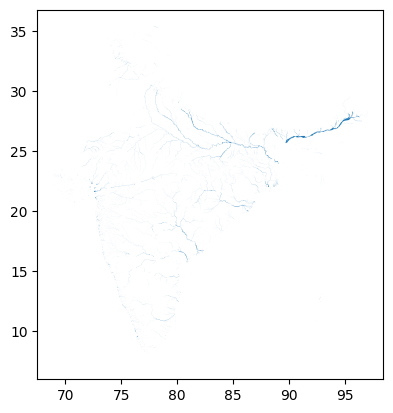

In [6]:
# merge all the polygons in rivers_india that touch
from shapely.ops import unary_union


rivers_india_merged_geom = unary_union(rivers_india.geometry)
rivers_india_merged = gpd.GeoDataFrame(geometry=[rivers_india_merged_geom], crs=rivers_india.crs).explode()

rivers_india_merged.plot()


## Keep only the observations that have approved annotations

In [15]:
df_sample = pd.concat(dfs)
df_sample = df_sample[(df_sample['Done labels'] > 0) & 
          (~df_sample[['latitude', 'longitude']].isna().any(axis = 1))]
df_sample = df_sample[~df_sample[['latitude', 'longitude']].isna().any(axis = 1)]

In [16]:
print(df_sample.shape)

(35, 5)


<AxesSubplot: >

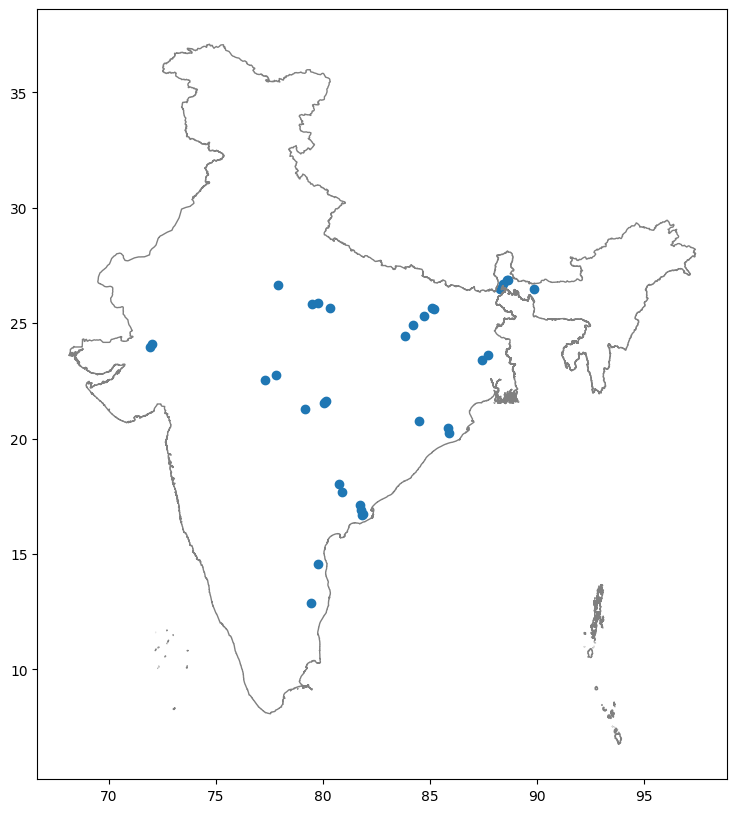

In [18]:
gdf_sample = gpd.GeoDataFrame(
    df_sample, geometry=gpd.points_from_xy(x=df_sample.longitude, y=df_sample.latitude)
)
gdf_sample = gdf_sample.set_crs(4326,allow_override=True )

fig, ax = plt.subplots(figsize=(10, 10))

gdf_sample.plot(ax=ax)
df_india.plot(facecolor = 'None', edgecolor = 'grey', ax = ax)

# HDBSCAN clustering of sites

Number of clusters: 10 / Number of unassigned points : 0


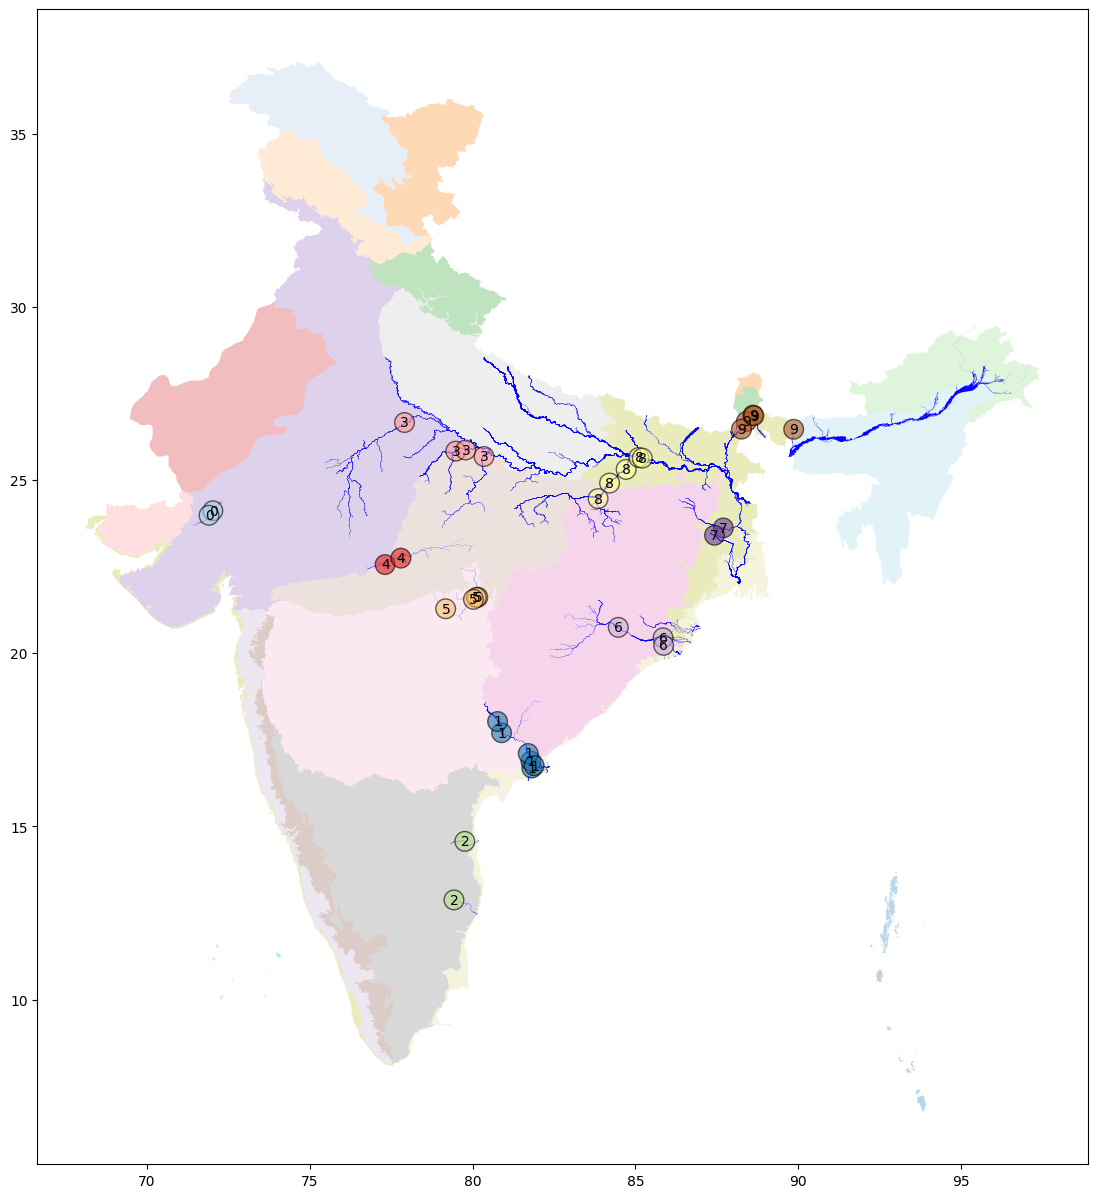

In [84]:
backgrounds = [india_bio]

gdf_sample = cluster_observations(gdf_sample, maximum_cluster_radius_km=200)
visualize_clusters(gdf_sample, rivers_gdf=rivers_india_merged ,background_gdfs=backgrounds)

## Determining annotation importance by clustering all sites 

<AxesSubplot: >

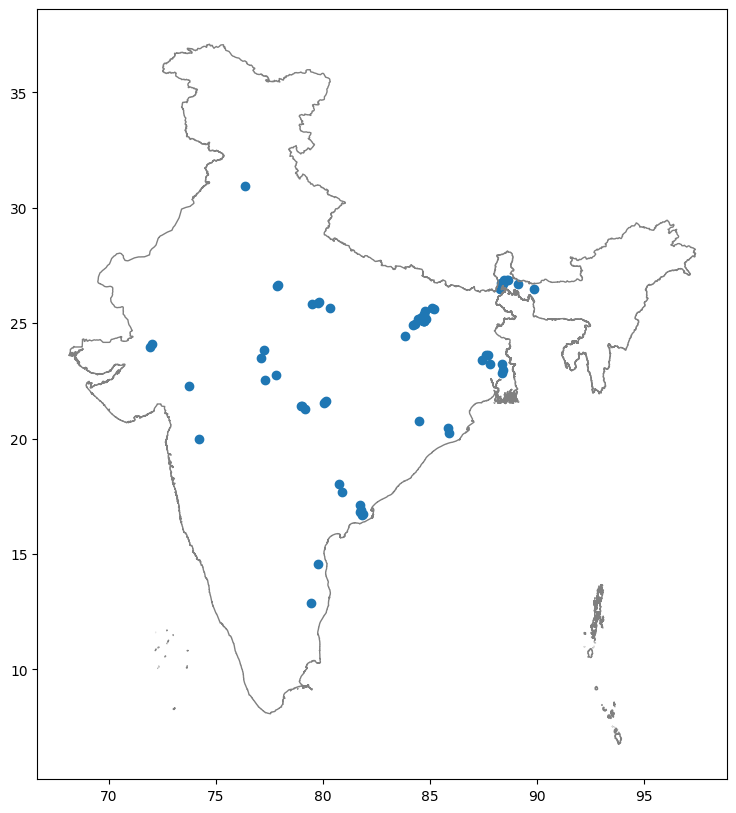

In [79]:
df_all = pd.concat(dfs)
df_all = df_all[~df_all[['latitude', 'longitude']].isna().any(axis = 1)]

gdf_all = gpd.GeoDataFrame(
    df_all, geometry=gpd.points_from_xy(x=df_all.longitude, y=df_all.latitude)
)
gdf_all = gdf_all.set_crs(4326,allow_override=True )

fig, ax = plt.subplots(figsize=(10, 10))

gdf_all.plot(ax=ax)
df_india.plot(facecolor = 'None', edgecolor = 'grey', ax = ax)

Number of clusters: 11 / Number of unassigned points : 1


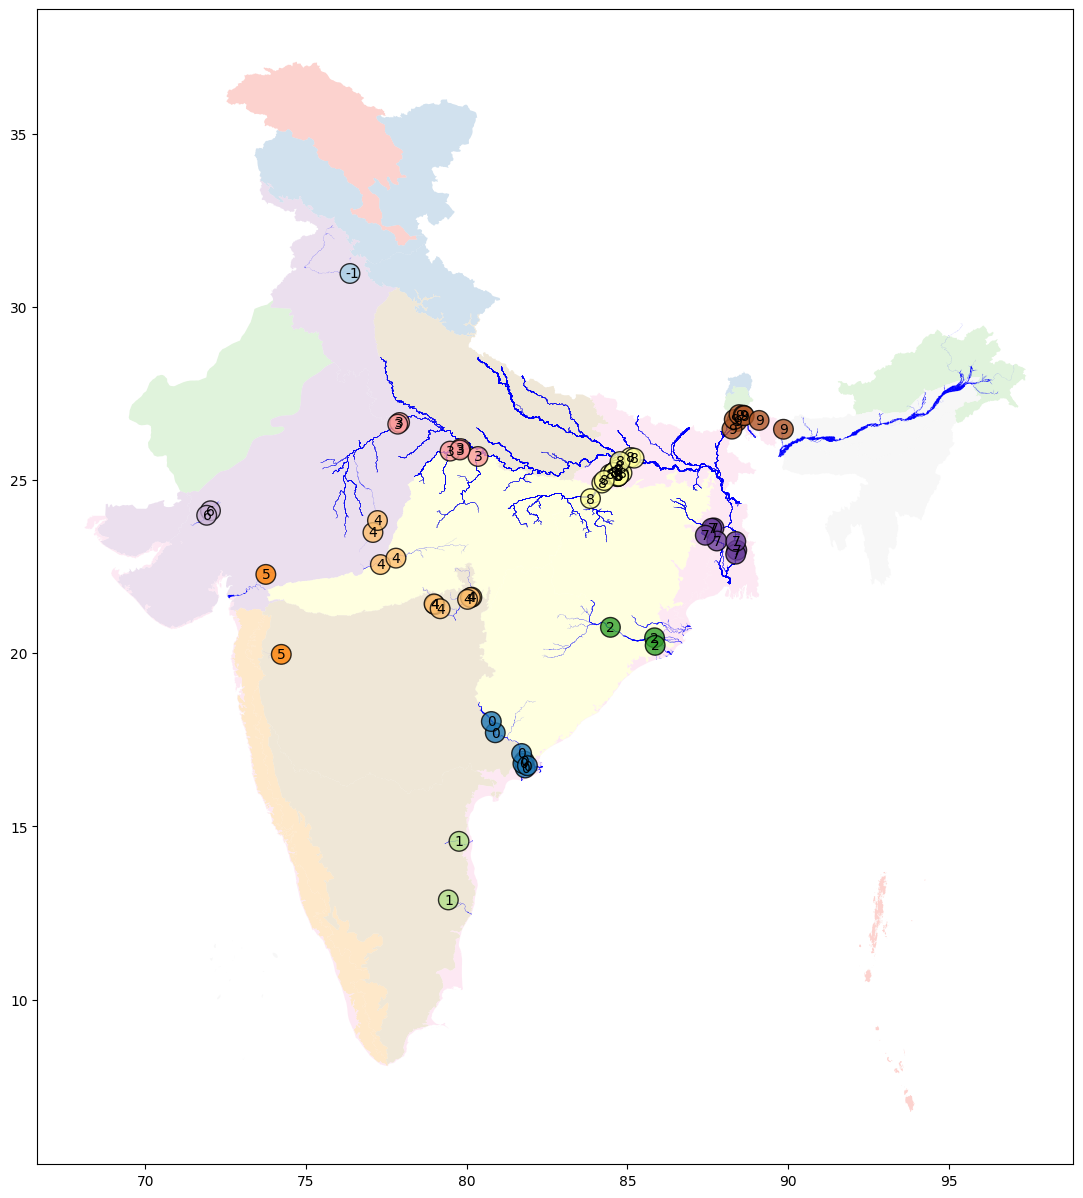

In [81]:
gdf_all = cluster_observations(gdf_all, maximum_cluster_radius_km=200)
visualize_clusters(gdf_all, rivers_gdf=rivers_india_merged ,background_gdfs=backgrounds)

### Regions to annotate:

1. North East - Brahmaputra
2. North West
3. South West

## Original Work to manually select clusters (ignore)

In [16]:
df_join = gpd.sjoin(gdf_sample, india_bio, how = 'inner')
df_join = df_join.to_crs('epsg:4326')

In [17]:
df_join.biogeozone.value_counts()

biogeozone
Deccan Peninsula    18
Gangetic Plain      12
Semi-Arid            5
Coasts               4
Name: count, dtype: int64

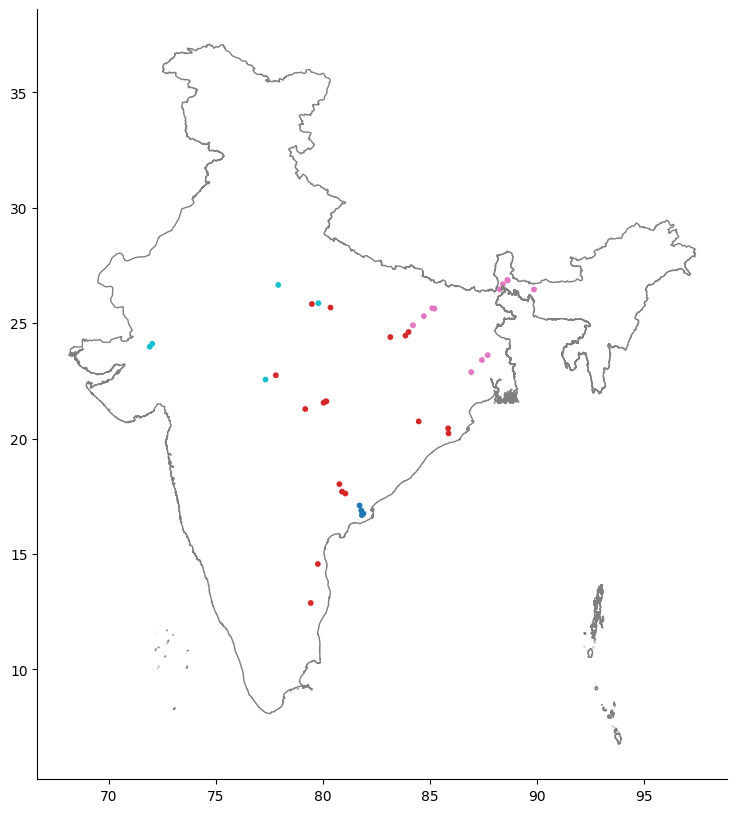

In [10]:
fig, ax = plt.subplots(figsize = (10, 10))
df_join.plot(column = 'biogeozone', facecolor = 'None', ax = ax, markersize = 10)
df_india.plot(facecolor = 'None', edgecolor = 'grey',  ax = ax)
sns.despine()
plt.show()

In [11]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [12]:
df_join1 = df_join.to_crs("epsg:32644")
df_join1['x'] = df_join1['geometry'].x
df_join1['y'] = df_join1['geometry'].y

X = df_join1[['x', 'y']].values


kmeans = AgglomerativeClustering(distance_threshold = 100000, n_clusters = None, linkage = 'single').fit(X)
df_join1[f'ag_means'] = kmeans.labels_

df_join1['cat'] = np.where(df_join1['latitude'] < 21.9, 1, 
         np.where(df_join1['longitude']< 82.5, 2, 3))


<Axes: xlabel='ag_means'>

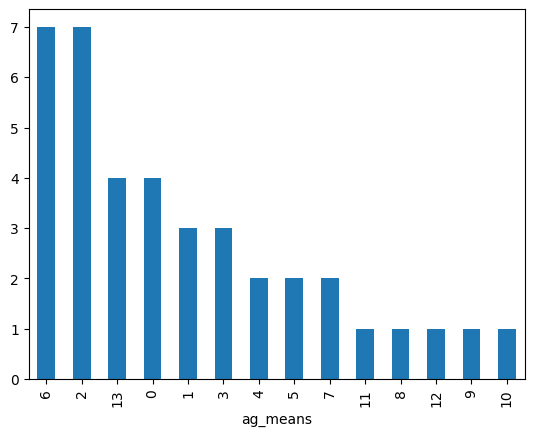

In [13]:
df_join1.ag_means.value_counts().plot(kind = 'bar')

In [14]:
df_join1.cat.value_counts()

cat
1    16
3    15
2     8
Name: count, dtype: int64

In [15]:
df_clusters = df_join1.ag_means.value_counts().reset_index()
df_clusters['cluster_group'] = df_clusters['count'].map({7: np.nan,  4:np.nan, 3:2, 2:3, 1:4})

In [16]:
# df_clusters[~df_clusters.ag_means.isin([6, 2, 13, 10])].groupby('cluster_group').sample(random_state = 42)

In [17]:
df_join1[df_join1.Id.isin(['n-4', 'b-22'])]

,Id,latitude,longitude,Done labels,geometry,index_right,__mlocate_,__mlocate0,__mlocate1,__mlocate2,...,__mlocate8,prov_code,biogeozone,biogeoprov,zone_code,area_sqkm,x,y,ag_means,cat
21,b-22,23.616222,87.69767,2.0,POINT (1184297.341 2627810.430),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.184297e+06,2.627810e+06,1,3
3,n-4,22.880000,86.93000,2.0,POINT (1109014.977 2542519.338),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.109015e+06,2.542519e+06,1,3


In [18]:
df_join1[(df_join1.cat == 1) &  
         (~df_join1.ag_means.isin([6, 2, 13, 0]))].drop_duplicates('ag_means').groupby('cat').sample(3, random_state = 154)

,Id,latitude,longitude,Done labels,geometry,index_right,__mlocate_,__mlocate0,__mlocate1,__mlocate2,...,__mlocate8,prov_code,biogeozone,biogeoprov,zone_code,area_sqkm,x,y,ag_means,cat
3,b-4,20.444176,85.847991,2.0,POINT (1006147.345 2268127.113),16,174691.0,156.0,1,0.0,...,2009-02-16,6C,Deccan Peninsula,Deccan Peninsula: Eastern Highlands,6,208121.91,1.006147e+06,2.268127e+06,5,1
27,b-27,12.876679,79.430004,2.0,POINT (329644.494 1424018.419),18,174693.0,156.0,1,0.0,...,2009-02-16,6E,Deccan Peninsula,Deccan Peninsula: Deccan South,6,342625.73,3.296445e+05,1.424018e+06,9,1
30,b-30,14.567470,79.762855,2.0,POINT (366724.988 1610849.097),18,174693.0,156.0,1,0.0,...,2009-02-16,6E,Deccan Peninsula,Deccan Peninsula: Deccan South,6,342625.73,3.667250e+05,1.610849e+06,10,1


In [19]:
df_join1[(df_join1.cat ==3) &  
         (~df_join1.ag_means.isin([6, 2, 13, 0]))].drop_duplicates('ag_means').groupby('cat').sample(2, random_state = 154)

,Id,latitude,longitude,Done labels,geometry,index_right,__mlocate_,__mlocate0,__mlocate1,__mlocate2,...,__mlocate8,prov_code,biogeozone,biogeoprov,zone_code,area_sqkm,x,y,ag_means,cat
21,b-22,23.616222,87.69767,2.0,POINT (1184297.341 2627810.430),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.184297e+06,2.627810e+06,1,3
17,v-17,26.463822,89.85844,2.0,POINT (1385159.188 2957705.041),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.385159e+06,2.957705e+06,8,3


In [20]:
df_join1[(df_join1.cat == 2) &  
         (~df_join1.ag_means.isin([6, 2, 13, 0]))].drop_duplicates('ag_means').groupby('cat').sample(1, random_state = 154)

,Id,latitude,longitude,Done labels,geometry,index_right,__mlocate_,__mlocate0,__mlocate1,__mlocate2,...,__mlocate8,prov_code,biogeozone,biogeoprov,zone_code,area_sqkm,x,y,ag_means,cat
0,b-1,26.659186,77.912883,2.0,POINT (192703.695 2952404.704),11,174686.0,156.0,1,0.0,...,2009-02-16,4B,Semi-Arid,Semi-Arid: Gujarat Rajputana,4,421857.93,192703.694949,2.952405e+06,11,2


In [21]:
df_join1[df_join1['ag_means'].isin([5, 9, 8, 1, 11, 10])]

,Id,latitude,longitude,Done labels,geometry,index_right,__mlocate_,__mlocate0,__mlocate1,__mlocate2,...,__mlocate8,prov_code,biogeozone,biogeoprov,zone_code,area_sqkm,x,y,ag_means,cat
0,b-1,26.659186,77.912883,2.0,POINT (192703.695 2952404.704),11,174686.0,156.0,1,0.0,...,2009-02-16,4B,Semi-Arid,Semi-Arid: Gujarat Rajputana,4,421857.93,1.927037e+05,2.952405e+06,11,2
3,b-4,20.444176,85.847991,2.0,POINT (1006147.345 2268127.113),16,174691.0,156.0,1,0.0,...,2009-02-16,6C,Deccan Peninsula,Deccan Peninsula: Eastern Highlands,6,208121.91,1.006147e+06,2.268127e+06,5,1
5,v-6,20.226477,85.867090,2.0,POINT (1008859.853 2244028.474),16,174691.0,156.0,1,0.0,...,2009-02-16,6C,Deccan Peninsula,Deccan Peninsula: Eastern Highlands,6,208121.91,1.008860e+06,2.244028e+06,5,1
21,b-22,23.616222,87.697670,2.0,POINT (1184297.341 2627810.430),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.184297e+06,2.627810e+06,1,3
24,b-24.1,23.404413,87.427526,2.0,POINT (1157674.389 2602984.407),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.157674e+06,2.602984e+06,1,3
17,v-17,26.463822,89.858440,2.0,POINT (1385159.188 2957705.041),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.385159e+06,2.957705e+06,8,3
3,n-4,22.880000,86.930000,2.0,POINT (1109014.977 2542519.338),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.109015e+06,2.542519e+06,1,3
27,b-27,12.876679,79.430004,2.0,POINT (329644.494 1424018.419),18,174693.0,156.0,1,0.0,...,2009-02-16,6E,Deccan Peninsula,Deccan Peninsula: Deccan South,6,342625.73,3.296445e+05,1.424018e+06,9,1
30,b-30,14.567470,79.762855,2.0,POINT (366724.988 1610849.097),18,174693.0,156.0,1,0.0,...,2009-02-16,6E,Deccan Peninsula,Deccan Peninsula: Deccan South,6,342625.73,3.667250e+05,1.610849e+06,10,1


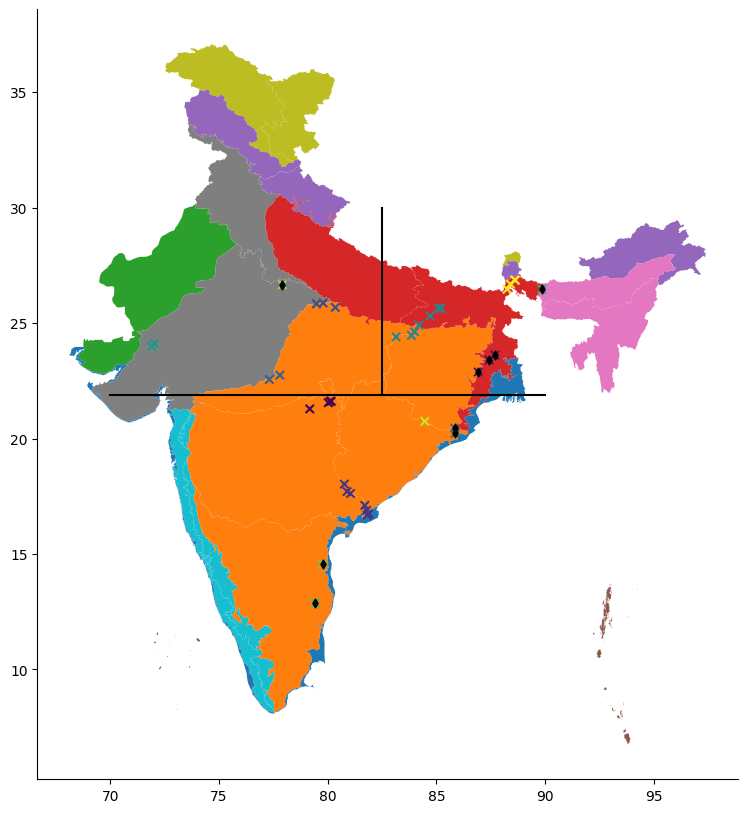

In [22]:
fig, ax = plt.subplots(figsize = (10, 10))
india_bio.plot(column = 'biogeozone', ax = ax)
df_join1.to_crs('epsg:4326').plot(column = 'ag_means', ax = ax, marker = 'x')
plt.plot([82.5, 82.5], [21.9, 30], 'k-')
plt.plot([70, 90], [21.9, 21.9], 'k-')
df_join1[df_join1['ag_means'].isin([5, 9, 8, 1, 11, 10])].to_crs('epsg:4326').plot(marker = 'd', color = 'black', markersize = 20,
                                                                              ax = ax)
sns.despine()
plt.show()

<Axes: xlabel='ag_means'>

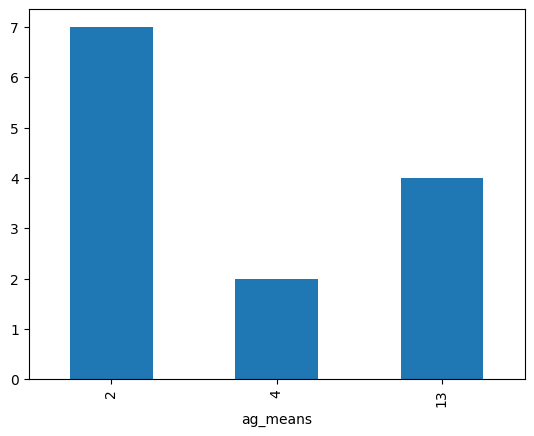

In [23]:
df_join1[df_join1['ag_means'].isin([2, 4, 13])].groupby('ag_means').size().plot(kind = 'bar')

<Axes: xlabel='cat,ag_means'>

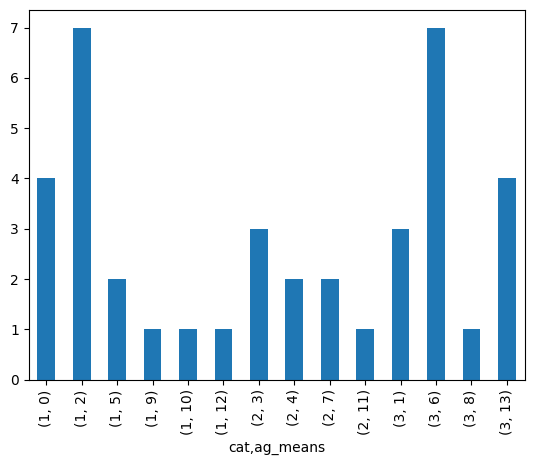

In [24]:
df_join1.groupby(['cat', 'ag_means']).size().plot(kind = 'bar')

In [25]:
X = df_join[['latitude', 'longitude']].values

kmeans_vals = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init="auto").fit(X)
    kmeans_vals.append(kmeans)

In [26]:
df_join1 = df_join.copy()

In [27]:
i = 1
for d in kmeans_vals:
    df_join1[f'means_{i}'] = d.labels_
    i+=1

<Axes: xlabel='means_6'>

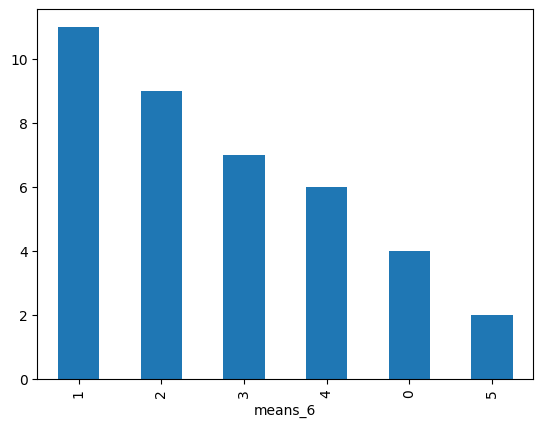

In [28]:
df_join1['means_6'].value_counts().plot(kind = 'bar')

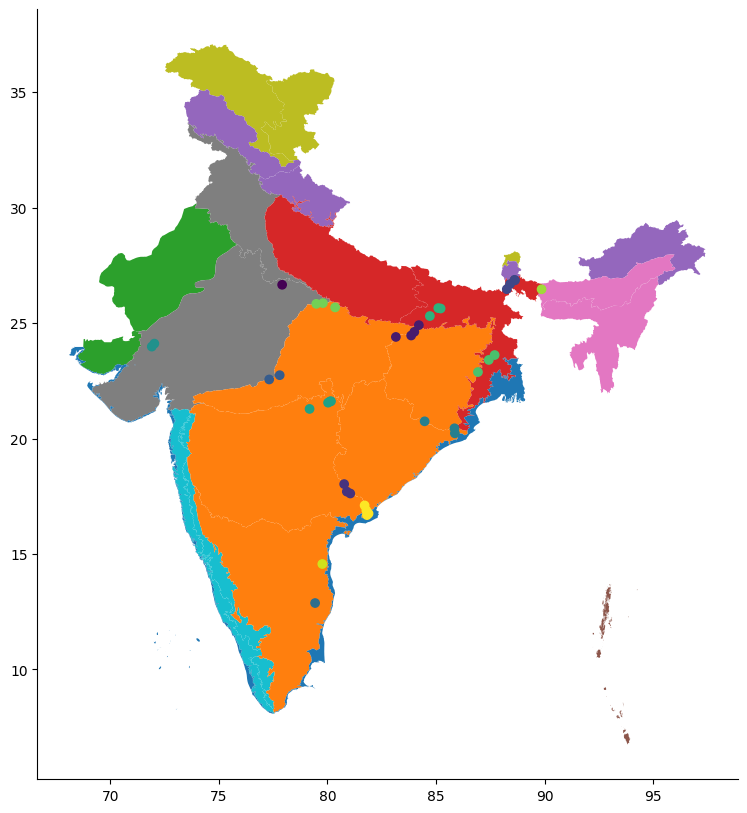

In [29]:
fig, ax = plt.subplots(figsize = (10, 10))
india_bio.plot(column = 'biogeozone', ax = ax)
df_join1.plot(column = 'means_15', ax = ax)
sns.despine()
plt.show()

In [30]:
df_join1


,Id,latitude,longitude,Done labels,geometry,index_right,__mlocate_,__mlocate0,__mlocate1,__mlocate2,...,means_10,means_11,means_12,means_13,means_14,means_15,means_16,means_17,means_18,means_19
0,b-1,26.659186,77.912883,2.0,POINT (77.91288 26.65919),11,174686.0,156.0,1,0.0,...,0,0,0,0,0,0,0,0,0,0
4,b-5,22.558320,77.316661,2.0,POINT (77.31666 22.55832),11,174686.0,156.0,1,0.0,...,4,4,4,4,4,4,4,4,4,4
39,b-39,24.111343,72.028424,2.0,POINT (72.02842 24.11134),11,174686.0,156.0,1,0.0,...,7,7,7,7,7,7,7,7,7,7
40,b-40,23.981314,71.910015,2.0,POINT (71.91002 23.98131),11,174686.0,156.0,1,0.0,...,7,7,7,7,7,7,7,7,7,7
9,v-9.1,25.866047,79.790153,2.0,POINT (79.79015 25.86605),11,174686.0,156.0,1,0.0,...,0,0,11,11,11,11,11,11,11,11
2,b-3,25.678286,80.352105,2.0,POINT (80.35210 25.67829),14,174689.0,156.0,1,0.0,...,0,0,11,11,11,11,11,11,11,11
7,b-8,22.744037,77.800522,2.0,POINT (77.80052 22.74404),14,174689.0,156.0,1,0.0,...,4,4,4,4,4,4,4,4,4,4
8,v-9,25.833518,79.484857,2.0,POINT (79.48486 25.83352),14,174689.0,156.0,1,0.0,...,0,0,11,11,11,11,11,11,11,11
1,n-2,24.620000,84.000000,2.0,POINT (84.00000 24.62000),14,174689.0,156.0,1,0.0,...,1,1,1,1,1,1,15,15,15,15
3,b-4,20.444176,85.847991,2.0,POINT (85.84799 20.44418),16,174691.0,156.0,1,0.0,...,6,6,6,6,6,6,6,6,6,6


In [52]:
from utils.river_utils import get_rivers_above
from project_config import RIVER_NETWORKS_DIR

# rivers_file = os.path.join(RIVER_NETWORKS_DIR, 'rivers-osm-india.geojson')
boundaries_file = os.path.join(RIVER_NETWORKS_DIR, 'gadm41_IND_0.json')

# rivers = gpd.read_file(rivers_file)
boundary = gpd.read_file(boundaries_file)
# rivers_above50km = get_rivers_above(rivers)

rivers_india = gpd.read_file(os.path.join(RIVER_NETWORKS_DIR, 'india-rivers_multipolygons.geojson'))
# rivers_india = gpd.read_file(os.path.join(RIVER_NETWORKS_DIR, 'rivers-osm-india_above50km.geojson'))



In [10]:
boundary = gpd.read_file(boundaries_file)

<Axes: >

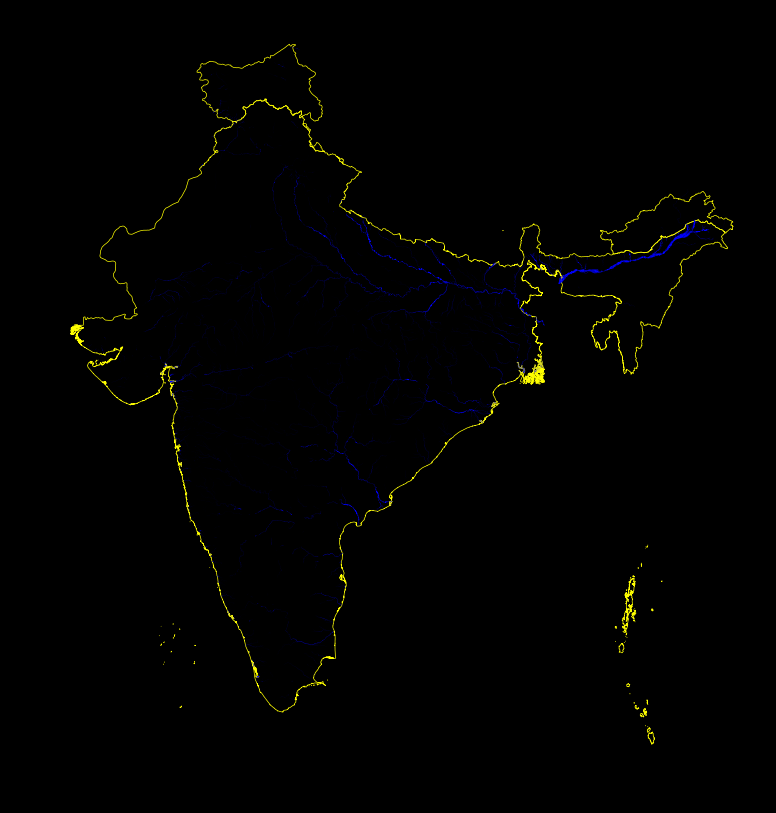

In [14]:
plt.figure(figsize=(10,10), facecolor='black')
#set background color to black
ax = plt.gca()
ax.set_facecolor('black')
# 
boundary.plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=0.5)
rivers_india.plot(ax=ax, linewidth=2.5, color='blue', facecolor='blue' )
#fill the rivers with blue color


<Axes: >

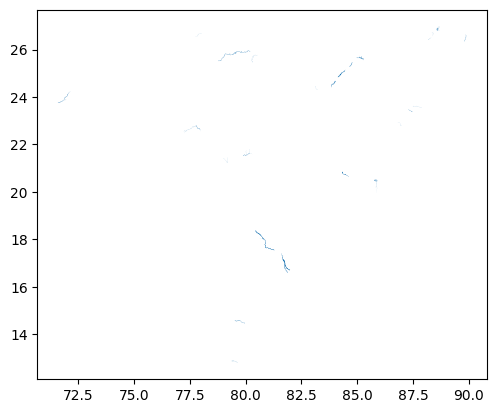

In [16]:
gdf_sample_buffer = gdf_sample.copy()
gdf_sample_buffer['geometry'] = gdf_sample.buffer(0.05)

# Perform the spatial join with the buffered points
rivers_sample = gpd.sjoin(rivers_india, gdf_sample_buffer, how="inner", op="intersects")
rivers_sample.plot(linewidth=10)

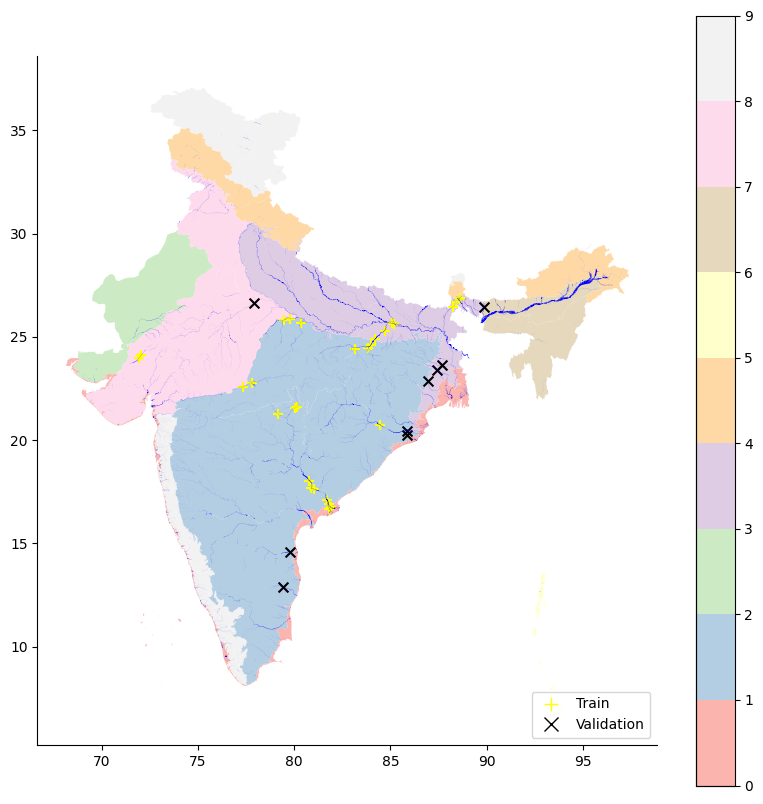

In [31]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize = (10, 10))
india_bio.plot(column = 'biogeozone', ax = ax, cmap='Pastel1')

rivers_sample.plot(ax=ax, linewidth=0.5, color='blue' )
gdf_sample[gdf_sample.split == 'TRAIN'].plot(ax=ax, color = 'yellow', markersize = 50, marker = '+')
gdf_sample[gdf_sample.split == 'VAL'].plot(ax=ax, color = 'red', markersize = 50, marker='x')
rivers_india.plot(ax=ax, linewidth=2.5, color='blue', facecolor='blue' )

#create a legend in the bottom right showing the 2 kinds of markers
legend_elements = [Line2D([0], [0], marker='+', color='yellow', label='Train',
                          markerfacecolor='yellow', markersize=10, linestyle='None'),
                   Line2D([0], [0], marker='x', color='red', label='Validation',
                          markerfacecolor='red', markersize=10, linestyle='None')]
                        #   + [Patch(facecolor=color, edgecolor=color, label=biogeozone) for biogeozone, color in colors.items()]

legend = ax.legend(handles=legend_elements, loc='lower right')
legend.get_frame().set_facecolor('darkgray')

ax.axis('off')
#remove axes markers

# fig.colorbar(mappable = biogeoplot.get_children()[0], ax=ax)

# ax.plot([72.5, 90], [20, 18], 'b-')
# ax.plot([77.5, 82.5], [14, 26], 'b-')
sns.despine()
plt.show()